# Random Forest Model for Kaggle G2F

This notebook implements a Random Forest classifier to predict `Win_YN` for the Kaggle G2F competition, replicating the logic from `rf_model.py`.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import os

# Set random seed for reproducibility
np.random.seed(123)

# For Jupyter Notebooks, plots are displayed inline
%matplotlib inline

## 1. Load Data

In [9]:
# Define paths
base_dir = os.getcwd()
data_dir = os.path.join(base_dir)
output_dir = base_dir

print(f"Base directory: {base_dir}")
print(f"Data directory: {data_dir}")

# Load datasets
print("Loading data...")
try:
    data = pd.read_csv(os.path.join(data_dir, "G2F_data.csv"))
    kaggle_prediction = pd.read_csv(os.path.join(data_dir, "kaggle_prediction.csv"))
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    raise e

Base directory: /Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/COMPETITION/Kaggle_G2F
Data directory: /Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/COMPETITION/Kaggle_G2F
Loading data...
Data loaded successfully.


## 2. Preprocessing

Perform the following preprocessing steps:
1. **Environment Variable**: Ensure `Env` is treated as a categorical string variable.
2. **Combine Datasets**: Combine the training data and Kaggle prediction data to ensure consistent One-Hot Encoding across both datasets. (`is_train` flag is added to separate them later)
3. **Target Separation**: Separate the target variable `Win_YN` from the features.
4. **One-Hot Encoding**: Convert categorical variables into numerical dummy variables using `pd.get_dummies` with `drop_first=True` to avoid multicollinearity.
5. **Split Data**: Separate the combined dataset back into training and prediction sets using the `is_train` flag.

In [10]:
print("Preprocessing data...")

# Ensure 'Env' is treated as categorical (string) 
data['Env'] = data['Env'].astype(str)
kaggle_prediction['Env'] = kaggle_prediction['Env'].astype(str)

# Handle categorical variables using One-Hot Encoding (pd.get_dummies)
# Combine train and prediction data to ensure consistent columns
# Add a flag to distinguish them later
data['is_train'] = 1
kaggle_prediction['is_train'] = 0

# The target variable 'Win_YN' is in data but not kaggle_prediction
# separate it before encoding features
target = data['Win_YN']
data_features = data.drop(columns=['Win_YN'])

# Combine for encoding
combined = pd.concat([data_features, kaggle_prediction], axis=0, ignore_index=True)

# Identify categorical columns (excluding the flag)
categorical_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# One-hot encode
combined_encoded = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)

# Split back into train and prediction sets
train_data_processed = combined_encoded[combined_encoded['is_train'] == 1].drop(columns=['is_train'])
kaggle_prediction_processed = combined_encoded[combined_encoded['is_train'] == 0].drop(columns=['is_train'])

Preprocessing data...
Categorical columns: ['Hybrid', 'Env', 'field_location']


## 3. Train/Test Split

In [11]:
# Split training data into Train and Test (Validation) sets
X = train_data_processed
y = target

# Ensure target is encoded if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Encoded target classes: {le.classes_}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Encoded target classes: ['N' 'Y']
Train shape: (1651, 298), Test shape: (1651, 298)


## 4. Train Random Forest Model

In [12]:
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)
print("Model trained.")

Training Random Forest model...
Model trained.


## 5. Evaluation

Evaluating model...
Confusion Matrix:
[[801 173]
 [164 513]]
Accuracy: 0.796
AUC: 0.880


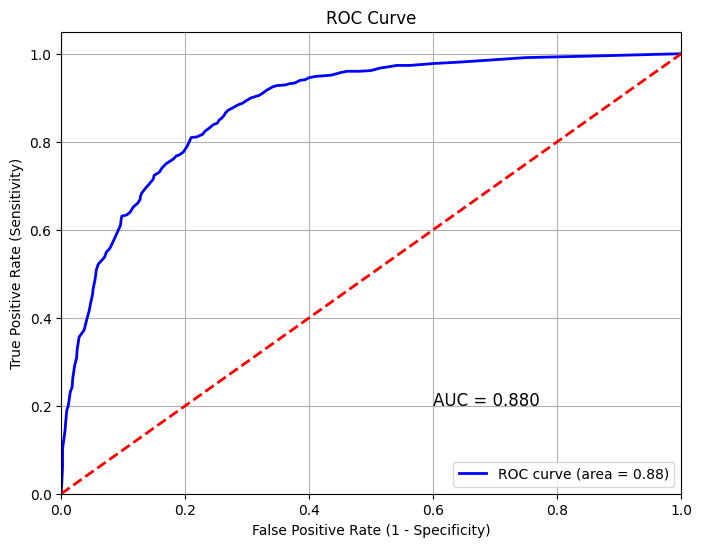

In [13]:
print("Evaluating model...")
test_predictions = rf_model.predict(X_test)
test_probs = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix and Accuracy
conf_matrix = confusion_matrix(y_test, test_predictions)
accuracy = accuracy_score(y_test, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.6, 0.2, f"AUC = {roc_auc:.3f}", fontsize=12)
plt.grid(True)
plt.show()

## 6. Kaggle Predictions

In [14]:
print("Generating Kaggle predictions...")
kaggle_preds = rf_model.predict(kaggle_prediction_processed)

# Create output dataframe
kaggle_output = pd.DataFrame({
    'ID': range(1, len(kaggle_preds) + 1),
    'hybrid_binomial': kaggle_preds
})

# If the target was label encoded, inverse transform
if 'le' in locals():
    kaggle_output['hybrid_binomial'] = le.inverse_transform(kaggle_output['hybrid_binomial'])

output_file = os.path.join(output_dir, "kaggle_prediction_output_rf_notebook.csv")
kaggle_output.to_csv(output_file, index=False)
print(f"Kaggle output saved to {output_file}")

# Display first few rows
kaggle_output.head()

Generating Kaggle predictions...
Kaggle output saved to /Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/COMPETITION/Kaggle_G2F/kaggle_prediction_output_rf_notebook.csv


,ID,hybrid_binomial
0,1,Y
1,2,Y
2,3,N
3,4,N
4,5,N
